# Contrastive Loss

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf

import matplotlib.pyplot as plt
from ipywidgets import interact

import tensorflow_addons as tfa
from tensorflow.keras.models import load_model
# from tensorflow_addons.losses import TripletSemiHardLoss, TripletHardLoss

from beeid.utils import sensitivity_map

from code.models import simple_cnnv2, ContrastiveLearning
from code.data_utils import load_tf_pair_dataset, load_tf_dataset
from code.viz import show_sensitivity_maps
from code.evaluation import cmc_evaluation, plot_cmc
from code.evaluation import get_interactive_plot_query_gallery

IMAGE_FOLDER = "/mnt/storage/work/jchan/normalized_uncensored_dataset/images/"
DATASET_CSV = "/mnt/storage/work/jchan/body_dataset2/dataset3.csv"

### Prepare dataset

Select the dates for Training, Validation and Testing datasets.

In [2]:
# def filter_dataframe(df):
#     filtered_df = df[(df.closest_bee > 300)]
#     filtered_df = filtered_df[filtered_df.abdomen_size >= 230]
#     filtered_df = filtered_df[filtered_df.abdomen_angle >= 200]
#     filtered_df = filtered_df[filtered_df.abdomen_angle <= 330]
#     filtered_df = filtered_df[filtered_df.V_mean >= 0.30]
#     return filtered_df.copy()

# df = pd.read_csv(DATASET_CSV)

# df = filter_dataframe(df)
# df= df[df.tag_id != -1.0]
# df["datetime2"] = pd.to_datetime(df["datetime"])
# df["days"] = df["datetime2"].dt.strftime("%Y-%m-%d")
# df["global_track_id"] = df["video_name"] + "_" + df["track_id"].apply(str)
# df["filename"] = IMAGE_FOLDER + df.filename

# train_df = df[df.days <= '2019-07-23']
# valid_df = df[(df.days > '2019-07-23') & (df.days < '2019-07-25')]
# test_df = df[(df.days >= '2019-08-01') & (df.days <= '2019-08-04')]

train_df=pd.read_csv("data/train.csv")
test_df=pd.read_csv("data/test.csv")
valid_df=pd.read_csv("data/valid.csv")

len(train_df), len(valid_df), len(test_df)

(3777, 1909, 3276)

### Create Pairs

In [3]:
def determine_cutoff(labels, batch_size=64, min_ids=50):
    batches = np.floor(len(labels)/batch_size).astype(int)
    for i in range(batches):
        batch = labels[i*batch_size:(i+1)*batch_size]
        nids = np.unique(batch)
        if len(nids) < min_ids:
            return i*batch_size

In [4]:
pair_train_df = train_df.merge(train_df, on="track_tag_id")
pair_train_df = pair_train_df.groupby("track_tag_id").sample(500, replace=True).drop_duplicates()
pair_train_df = pair_train_df.loc[pair_train_df.groupby("track_tag_id").cumcount().sort_values(kind='mergesort').index]

# avoid batches with multiple instances of the same ids
labels = pair_train_df.track_tag_id.values
cutoff = determine_cutoff(labels, batch_size=64, min_ids=50)
pair_train_df = pair_train_df.iloc[:cutoff]

In [5]:
pair_valid_df = valid_df.merge(valid_df, on="track_tag_id")
not_same_track = (pair_valid_df.global_track_id_x != pair_valid_df.global_track_id_y)
pair_valid_df = pair_valid_df[not_same_track]
pair_valid_df = pair_valid_df.groupby("track_tag_id").sample(250, replace=True).drop_duplicates()
pair_valid_df = pair_valid_df.loc[pair_valid_df.groupby("track_tag_id").cumcount().sort_values(kind='mergesort').index]

# avoid batches with multiple instances of the same ids
labels = pair_valid_df.track_tag_id.values
cutoff = determine_cutoff(labels, batch_size=20, min_ids=20)
pair_valid_df = pair_valid_df.iloc[:cutoff]

### Tensorflow Dataset

In [6]:
train_pair_dataset = load_tf_pair_dataset(pair_train_df, rescale_factor=4, augmentation=True).shuffle(len(pair_train_df)).batch(64)
valid_pair_dataset = load_tf_pair_dataset(pair_valid_df, rescale_factor=4).batch(20)
valid_dataset = load_tf_dataset(valid_df, rescale_factor=4)

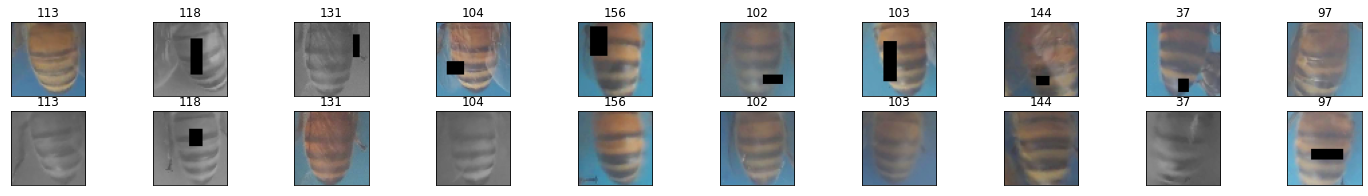

In [7]:
data = train_pair_dataset
gen = iter(data)
sample_batch = next(gen)

EXAMPLES=2

fig, ax = plt.subplots(EXAMPLES, 10, figsize=(25, 3))

for j in range(10):
    ax[0, j].imshow(sample_batch[0][j])
    ax[1, j].imshow(sample_batch[1][j])
    ax[0, j].set_title("{}".format(sample_batch[2][j].numpy()))
    ax[1, j].set_title("{}".format(sample_batch[2][j].numpy()))
    ax[0, j].set_xticks([])
    ax[0, j].set_yticks([])
    ax[1, j].set_xticks([])
    ax[1, j].set_yticks([])

### Model

In [9]:
backbone = simple_cnnv2(input_shape=(56, 56, 3), conv_blocks=3, latent_dim=128)
backbone.load_weights("weights/pretraining_contrastive_loss_t0-1_backbone.h5")
model = ContrastiveLearning(backbone, temperature=0.1)

In [10]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.001))

In [ ]:
# Train the network
EPOCHS=1000
PATIENCE=100


earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

history = model.fit(train_pair_dataset, validation_data=valid_pair_dataset, epochs=EPOCHS, callbacks=[earlystop])

Epoch 1/1000
346/346 [==============================] - 23s 67ms/step - loss: 3.9699 - val_loss: 3.1352
Epoch 2/1000
346/346 [==============================] - 22s 63ms/step - loss: 2.8709 - val_loss: 3.0436
Epoch 3/1000
346/346 [==============================] - 21s 61ms/step - loss: 2.3947 - val_loss: 2.9691
Epoch 4/1000
346/346 [==============================] - 21s 61ms/step - loss: 2.1043 - val_loss: 3.1216
Epoch 5/1000
346/346 [==============================] - 21s 61ms/step - loss: 1.9334 - val_loss: 3.1399
Epoch 6/1000
346/346 [==============================] - 21s 61ms/step - loss: 1.7891 - val_loss: 3.1497
Epoch 7/1000
346/346 [==============================] - 21s 60ms/step - loss: 1.6890 - val_loss: 3.1981
Epoch 8/1000
346/346 [==============================] - 21s 61ms/step - loss: 1.5946 - val_loss: 3.3129
Epoch 9/1000
346/346 [==============================] - 21s 61ms/step - loss: 1.5546 - val_loss: 3.1347
Epoch 10/1000
346/346 [==============================] - 21s 61m

<AxesSubplot:>

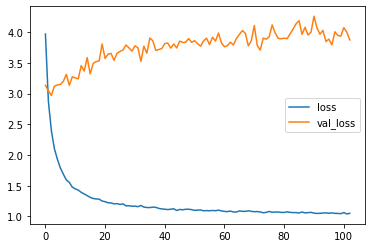

In [12]:
pd.DataFrame(history.history).plot()

### Checking Training

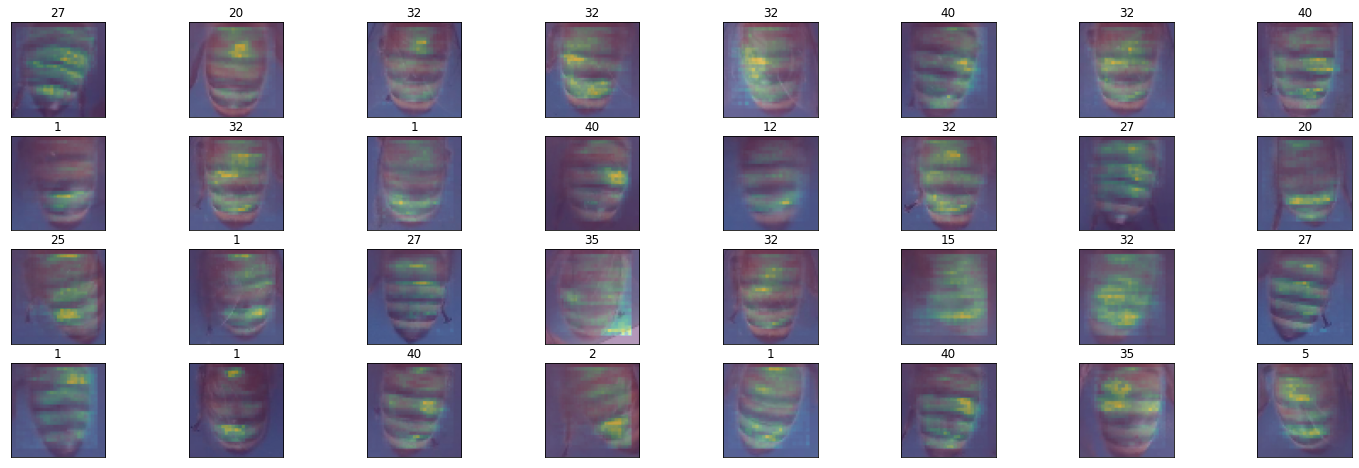

In [14]:
show_sensitivity_maps(model, valid_dataset)

#### Save model

In [15]:
model.save("models/contrastive_loss_T0-1_pretrained.tf")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/contrastive_loss_T0-1_pretrained.tf/assets


## Evaluation

In [18]:
ITERATIONS=100
GALLERY_SIZE=10

### Evaluation on ids shared with the training set (validation set)

100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


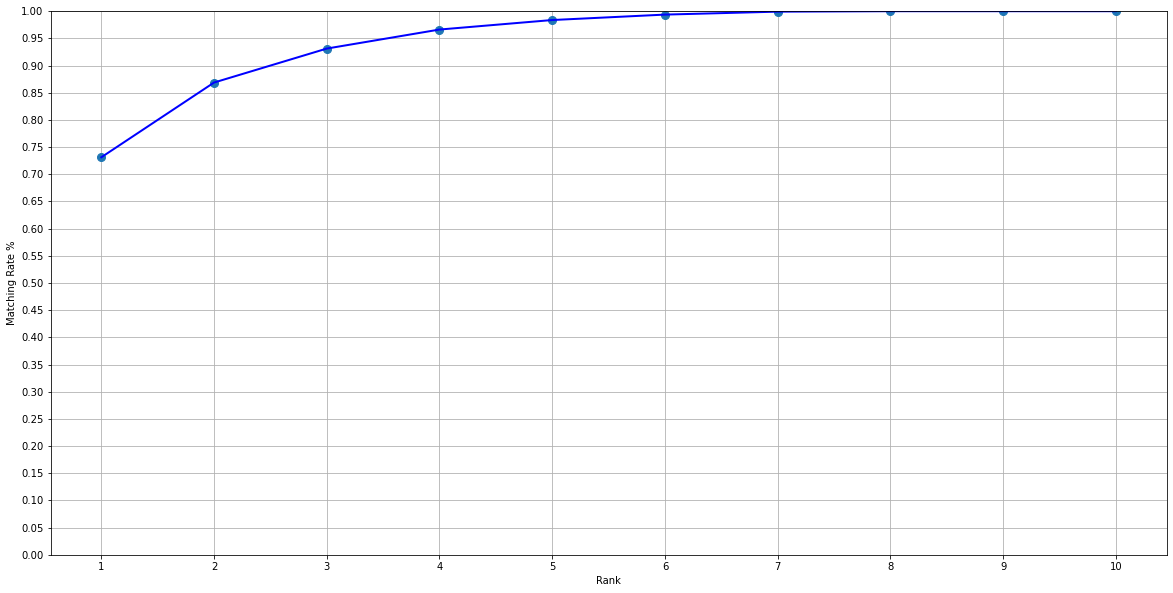

In [19]:
train_ids = train_df.track_tag_id.unique()

valid_with_shared_ids = valid_df[valid_df.track_tag_id.isin(train_ids)]

valid_with_shared_ids_ranks_means = cmc_evaluation(model, valid_with_shared_ids, iterations=ITERATIONS, gallery_size=GALLERY_SIZE)

plot_cmc(valid_with_shared_ids_ranks_means)

### Evaluation on ids shared with the whole validation set

100%|██████████| 100/100 [02:20<00:00,  1.41s/it]


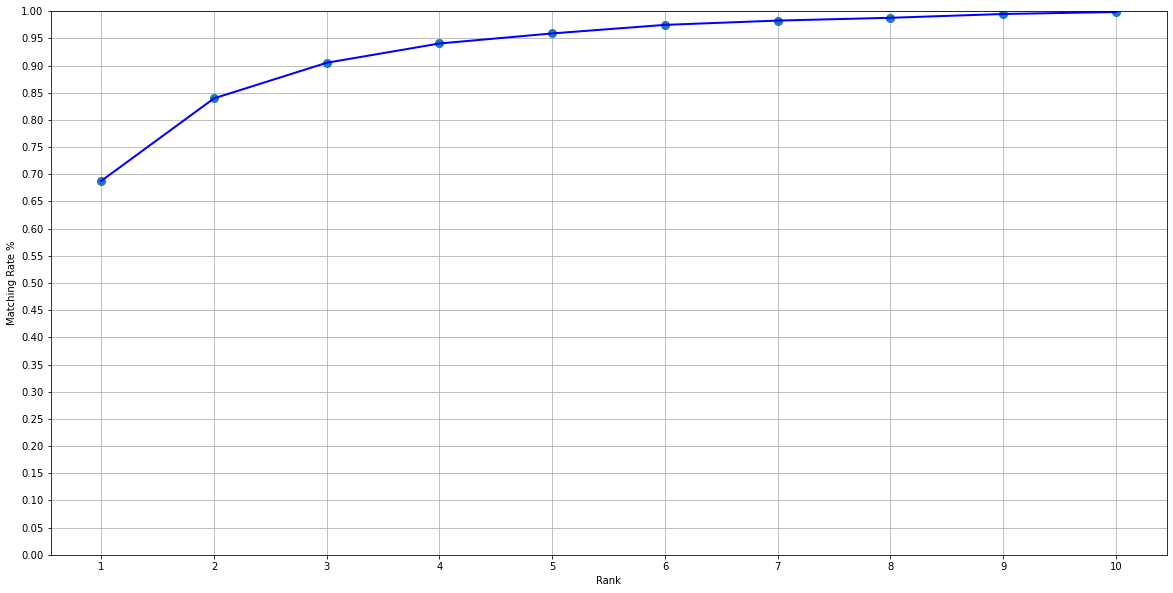

In [20]:
valid_ranks_means = cmc_evaluation(model, valid_df, iterations=ITERATIONS, gallery_size=GALLERY_SIZE)

plot_cmc(valid_ranks_means)

### Evaluation on test set

100%|██████████| 100/100 [12:42<00:00,  7.62s/it]


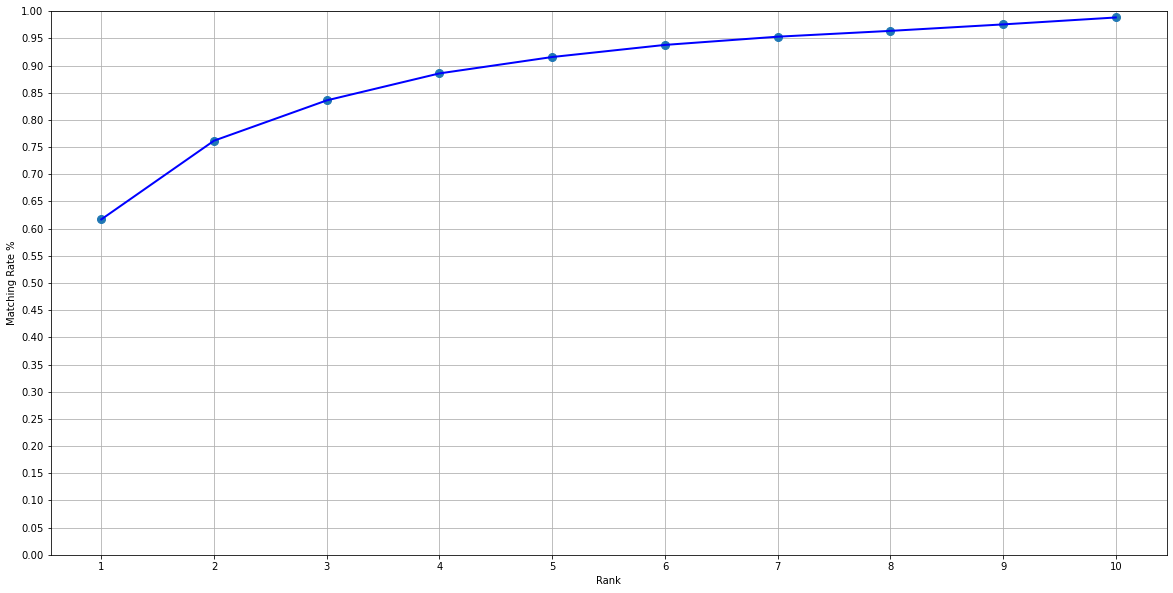

In [21]:
test_ranks_means = cmc_evaluation(model, test_df, iterations=ITERATIONS, gallery_size=GALLERY_SIZE)

plot_cmc(test_ranks_means)

In [22]:
train_ids = train_df.track_tag_id.unique()
test_ids = test_df.track_tag_id.unique()


intersection = set(train_ids) & set(test_ids)

print("Test set has {} Ids.".format(len(test_ids)))
print("Intersection of train and test set {}".format(len(intersection)))

Test set has 126 Ids.
Intersection of train and test set 29


100%|██████████| 100/100 [09:11<00:00,  5.52s/it]


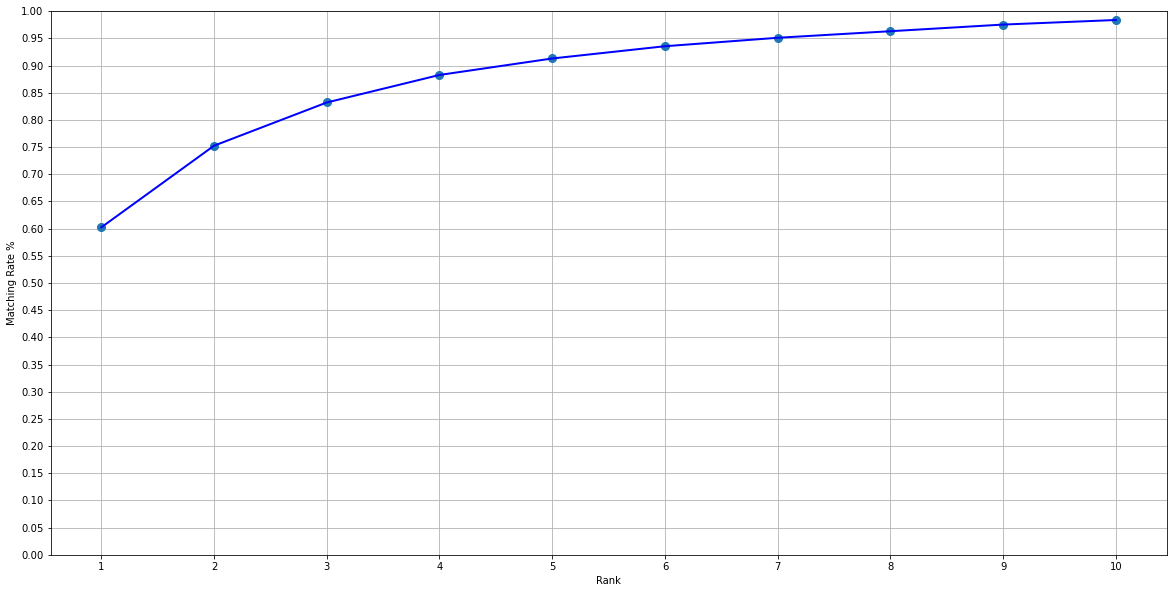

In [23]:
test_disjoint_train = test_df[~test_df.track_tag_id.isin(train_ids)]

test_disjoint_train_ranks_means = cmc_evaluation(model, test_disjoint_train, iterations=ITERATIONS, gallery_size=GALLERY_SIZE)

plot_cmc(test_disjoint_train_ranks_means)

#### Saving results

In [24]:
metric_dict = dict()

metric_dict["valid_cmc_only_train_ids"] = valid_with_shared_ids_ranks_means 
metric_dict["valid_cmc"] = valid_ranks_means
metric_dict["test_cmc"] = test_ranks_means
metric_dict["test_cmc_no_ids_overlap"] = test_disjoint_train_ranks_means

metric_df = pd.DataFrame(metric_dict)
metric_df.to_csv("results/contrastive_lossT0-1_pretrained.csv")

In [25]:
metric_df

,valid_cmc_only_train_ids,valid_cmc,test_cmc,test_cmc_no_ids_overlap
0,0.731250,0.687879,0.617024,0.602381
1,0.868750,0.839697,0.761786,0.752540
2,0.931250,0.905152,0.835952,0.832063
3,0.966250,0.940606,0.885595,0.882698
4,0.983750,0.959091,0.915714,0.913016
5,0.993750,0.974848,0.937976,0.935556
6,0.999167,0.982727,0.953095,0.951111
7,1.000000,0.987879,0.963810,0.963175
8,1.000000,0.994848,0.975714,0.975397
9,1.000000,0.998485,0.988452,0.983810


#### Interactive Query Plotting

In [17]:
get_interactive_plot_query_gallery(model, valid_df)

interactive(children=(IntSlider(value=17, description='query_id', max=34), Checkbox(value=False, description='…